In [1]:
pip install spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.1/140.1 kB 7.6 MB/s eta 0:00:00


In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D,ConvLSTM2D,Conv3D,Cropping2D
from keras.layers import Input, Dropout, TimeDistributed, RepeatVector,Activation
from keras.layers import MaxPooling2D, UpSampling2D, BatchNormalization,Flatten, Dense, Reshape, LSTM
from keras import losses, Sequential
from keras import layers
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.optimizers import RMSprop, Adam
import keras
import typing
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import networkx as nx
import numpy as np
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Dense, Activation, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from spektral.layers import GATConv, GCNConv

2023-06-25 00:37:41.067642: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Some Functions

In [3]:
def G_Lorenz(sigma,rho,beta,time_steps):

    historical_state = np.zeros((time_steps,300,3))
    current_state = initial_state
    for i in range(time_steps):
        current_state = update_state(G, current_state, alpha, sigma, rho, beta)
        historical_state[i,:,:] = current_state
    
    return current_state,historical_state

def update_state(G, state, alpha, sigma, rho, beta):
    new_state = state.copy()
    for node in G.nodes():
        neighbors = G.neighbors(node)
        x, y, z = state[node]
        dx = sigma*(y - x) 
        dx = dx + np.random.normal(0.5, 1, dx.shape)*0.1
        dy = x*(rho - z) - y
        dy = dy + np.random.normal(0.5, 1, dy.shape)*0.1

        dz = x*y - beta*z
        dz = dz + np.random.normal(0.5, 1, dz.shape)*0.1

        dx_neigh, dy_neigh, dz_neigh = np.mean([(state[neighbor]) for neighbor in neighbors], axis=0)
        new_state[node] = state[node] + alpha*np.array([dx+dx_neigh, dy+dy_neigh, dz+dz_neigh])+np.random.normal(0.5, 1, 3)*0.1
    return new_state

import networkx as nx



## watts_strogatz_graph + barabasi_albert_graph



In [4]:
initial_state =2*np.random.rand(300, 3)
# Define the coupling strength
alpha = 0.11

#G = nx.barabasi_albert_graph(300, 10) 
G = nx.watts_strogatz_graph(300, 150, 0.3)

In [5]:
# Get the adjacency matrix
adj_matrix = nx.adjacency_matrix(G)

# Convert to dense matrix format for printing
dense_matrix = adj_matrix.todense()
print(dense_matrix[4,:])

[0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1
 1 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 0
 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 0 1 0 1 1 1 0 0
 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0
 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0
 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1
 0 1 1 1]


# Data Generation

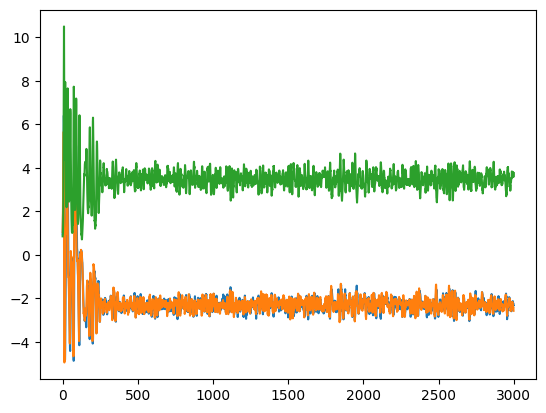

In [6]:
current_state_t3, historical_state_t3 = G_Lorenz(4.5,4.5,8/3,3000)
plt.plot(historical_state_t3[:,10,:])

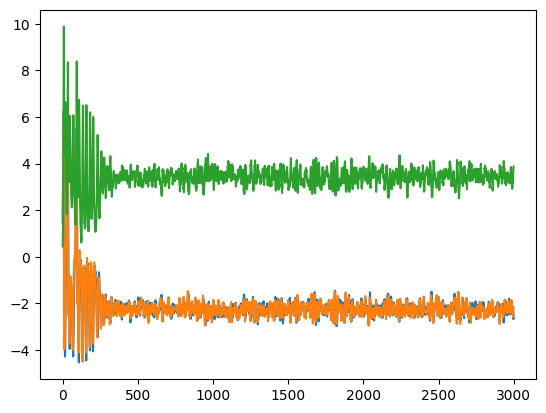

In [7]:
plt.plot(historical_state_t3[:,1,:])

In [8]:
# Adj Matrix and append set for GCN training
A = nx.to_numpy_array(G)

a_in = []
adjacency_matrix = pd.DataFrame(A)

for _ in range(2395):
  a_in.append(adjacency_matrix)
a_in = np.array(a_in)
a_valin = a_in[:595]

# Dataset Creation for LSTM 300，3 - > 900 + seperate creation 300,3 - > 300 + 3

In [9]:
train_dataset = historical_state_t3
train_len = len(train_dataset)
scaler = MinMaxScaler(feature_range = (0,1))
datasets = train_dataset.reshape(train_len,900)
datasets = scaler.fit_transform(datasets).astype('float32')

train_sca = datasets[:2400,:]
test_sca = datasets[2400:,:]

'''
train_sca = scaler.fit_transform(train).astype('float32')
test_sca = scaler.transform(valid).astype('float32')
'''
train_dataset = []
val_dataset = []
for i in range(len(train_sca)-4):
  a = pd.DataFrame(train_sca[i:i+4,:])
  train_dataset.append(a)

  #train_dataset = np.concat(a, axis=0)

for j in range(len(test_sca)-4):
  b = pd.DataFrame(test_sca[j:j+4])

  val_dataset.append(b)
'''
slices_train = np.split(train_sca[i:], len(train)/4)
train_dataset = np.stack(slices_train, axis=0)
slices_test = np.split(test_sca, len(valid)/4)
val_dataset = np.stack(slices_test, axis=0)
'''
train_dataset = np.array(train_dataset)
val_dataset = np.array(val_dataset)
def create_shifted_frames(data):
    x = data[0 : data.shape[0] - 1, :, :]
    y = data[1 : data.shape[0], :,:]
    return x, y
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
x_train.shape

(2395, 4, 900)

In [ ]:
A = 2395 # train size
B = 595  # valid size
time_step = 4
D = 300  # node numbers

In [ ]:
x_train, y_train = x_train.reshape(A, time_step, D,3), y_train.reshape(A, time_step, D,3)
x_val, y_val = x_val.reshape(B, time_step, D,3), y_val.reshape(B, time_step, D,3)

x_in = x_train[:,:,:,0].reshape(A, D,time_step)
x_out = y_train[:,:,:,0].reshape(A, D,time_step)

y_in = x_train[:,:,:,1].reshape(A, D,time_step)
y_out = y_train[:,:,:,1].reshape(A, D,time_step)

z_in = x_train[:,:,:,2].reshape(A, D,time_step)
z_out = y_train[:,:,:,2].reshape(A, D,time_step)

x_valin = x_val[:,:,:,0].reshape(B, D,time_step)
x_valout = y_val[:,:,:,0].reshape(B, D,time_step)

y_valin = x_val[:,:,:,1].reshape(B, D,time_step)
y_valout = y_val[:,:,:,1].reshape(B, D,time_step)

z_valin = x_val[:,:,:,2].reshape(B, D,time_step)
z_valout = y_val[:,:,:,2].reshape(B, D,time_step)

# GNN-LSTM Keras

In [10]:
!pip install ogb
!pip install OGB
!pip install spektral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7029 sha256=06f6427a75bb904942dab7a48c3353e1f569d1f0b2dbebcb28b6e6c323e55640
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
#train_dataset = np.vstack((historical_state_1,historical_state_t2,historical_state_t3))
train_dataset = historical_state_t3
train_len = len(train_dataset)
scaler = MinMaxScaler(feature_range = (0,1))
datasets = train_dataset.reshape(train_len,900)
datasets = scaler.fit_transform(datasets).astype('float32')

train_sca = datasets[:2400,:]
test_sca = datasets[2400:,:]

'''
train_sca = scaler.fit_transform(train).astype('float32')
test_sca = scaler.transform(valid).astype('float32')
'''
train_dataset = []
val_dataset = []
for i in range(len(train_sca)-4):
  a = pd.DataFrame(train_sca[i:i+4,:])
  train_dataset.append(a)

  #train_dataset = np.concat(a, axis=0)

for j in range(len(test_sca)-4):
  b = pd.DataFrame(test_sca[j:j+4])

  val_dataset.append(b)
'''
slices_train = np.split(train_sca[i:], len(train)/4)
train_dataset = np.stack(slices_train, axis=0)
slices_test = np.split(test_sca, len(valid)/4)
val_dataset = np.stack(slices_test, axis=0)
'''
train_dataset = np.array(train_dataset)
val_dataset = np.array(val_dataset)
def create_shifted_frames(data):
    x = data[0 : data.shape[0] - 1, :, :]
    y = data[1 : data.shape[0], :,:]
    return x, y
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)
x_train.shape

(2395, 4, 900)

In [12]:
train_size = 2395
test_size = 595
node_num = 300
x_train, y_train = x_train.reshape(train_size, 4, node_num,3), y_train.reshape(train_size, 4, node_num,3)
x_val, y_val = x_val.reshape(test_size, 4, node_num,3), y_val.reshape(test_size, 4, node_num,3)

x_in = x_train[:,:,:,0].reshape(train_size, node_num,4)
x_out = y_train[:,:,:,0].reshape(train_size, node_num,4)

y_in = x_train[:,:,:,1].reshape(train_size, node_num,4)
y_out = y_train[:,:,:,1].reshape(train_size, node_num,4)

z_in = x_train[:,:,:,2].reshape(train_size, node_num,4)
z_out = y_train[:,:,:,2].reshape(train_size, node_num,4)

x_valin = x_val[:,:,:,0].reshape(test_size, node_num,4)
x_valout = y_val[:,:,:,0].reshape(test_size, node_num,4)

y_valin = x_val[:,:,:,1].reshape(test_size, node_num,4)
y_valout = y_val[:,:,:,1].reshape(test_size, node_num,4)

z_valin = x_val[:,:,:,2].reshape(test_size, node_num,4)
z_valout = y_val[:,:,:,2].reshape(test_size, node_num,4)

In [12]:
from ogb.nodeproppred import Evaluator, NodePropPredDataset
from tensorflow.keras.layers import BatchNormalization, Dropout, Input
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.datasets.ogb import OGB
from spektral.layers import GCNConv,GATConv
from spektral.transforms import AdjToSpTensor, GCNFilter

In [13]:
import networkx as nx
import numpy as np
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.layers import Dense, Activation, LSTM, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from spektral.layers import GATConv, GCNConv

# Set hyperparameters
l2_reg = 5e-6
learning_rate = 0.2
epochs = 20000
patience = 200

# Set graph parameters
num_nodes = 300
num_features = 4
num_inputs = 3
num_outputs = 3
gcn_output_1 = 32
gcn_output_2 = 10
lstm_units_1 = 64
lstm_units_2 = 32

# Convert graph to adjacency matrix
adjacency_matrix = nx.to_numpy_array(G)

# Get node and neighbor indices
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)

# Define model inputs
inputs = []
for i in range(num_inputs):
    inputs.append(Input(shape=(num_nodes, num_features)))

# Define adjacency matrix inputs
adj_inputs = []
for i in range(num_inputs):
    adj_inputs.append(Input(shape=(num_nodes, num_nodes)))

# Define graph convolutional layers
gcn_layer_1 = GCNConv(gcn_output_1, activation="relu", use_bias=False,
                kernel_regularizer=l2(l2_reg))([inputs[0], adj_inputs[0]])
gcn_layer_2 = GCNConv(gcn_output_2, activation="relu", use_bias=False,
                kernel_regularizer=l2(l2_reg))([gcn_layer_1, adj_inputs[1]])

# Define LSTM layers
lstm_layer_1 = LSTM(lstm_units_1, return_sequences=True, activation="tanh")(gcn_layer_2)
lstm_layer_2 = LSTM(lstm_units_2, return_sequences=True, activation="tanh")(lstm_layer_1)

# Define dense layer and activation layer
dense_layer = TimeDistributed(Dense(units=num_features))(lstm_layer_2)
activation_layer = Activation('tanh')(dense_layer)

# Define model outputs
outputs = []
for i in range(num_outputs):
    outputs.append(activation_layer)

# Define model
model = Model(inputs=inputs + adj_inputs, outputs=outputs)
model.summary()

# Compile model
model.compile(loss='mse', optimizer='rmsprop')


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 4)]     0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 300, 300)]   0           []                               
                                                                                                  
 gcn_conv (GCNConv)             (None, 300, 32)      128         ['input_1[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 input_5 (InputLayer)           [(None, 300, 300)]   0           []                           

In [14]:
# Define the number of epochs and the patience for early stopping
epochs = 50
patience = 10

# Fit the model
history = model.fit(
    [x_in, y_in, z_in, a_in, a_in, a_in], 
    [x_out, y_out, z_out],
    validation_data=(
        [x_valin, y_valin, z_valin, a_valin, a_valin, a_valin],
        [x_valout, y_valout, z_valout]
    ),
    batch_size=4,
    epochs=epochs,
    callbacks=[
        EarlyStopping(patience=patience, restore_best_weights=True)
    ]
)


Epoch 1/50
599/599 [==============================] - 24s 24ms/step - loss: 0.1095 - activation_loss: 0.0451 - activation_1_loss: 0.0526 - activation_2_loss: 0.0117 - val_loss: 0.0980 - val_activation_loss: 0.0418 - val_activation_1_loss: 0.0500 - val_activation_2_loss: 0.0061
Epoch 2/50
599/599 [==============================] - 13s 21ms/step - loss: 0.1035 - activation_loss: 0.0430 - activation_1_loss: 0.0503 - activation_2_loss: 0.0101 - val_loss: 0.0976 - val_activation_loss: 0.0418 - val_activation_1_loss: 0.0501 - val_activation_2_loss: 0.0056
Epoch 3/50
599/599 [==============================] - 13s 21ms/step - loss: 0.1033 - activation_loss: 0.0429 - activation_1_loss: 0.0502 - activation_2_loss: 0.0101 - val_loss: 0.0992 - val_activation_loss: 0.0433 - val_activation_1_loss: 0.0522 - val_activation_2_loss: 0.0036
Epoch 4/50
599/599 [==============================] - 13s 21ms/step - loss: 0.1030 - activation_loss: 0.0428 - activation_1_loss: 0.0501 - activation_2_loss: 0.0100 -

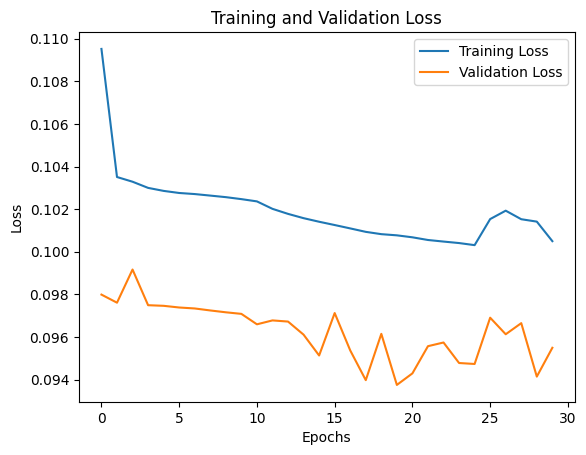

In [15]:
# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()